<a href="https://colab.research.google.com/github/PhuongThiDo/dothiphuong.github.io/blob/main/Medical_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

base_dir = '/content/drive/MyDrive/Datasets/chest_xray'


train_dir = os.path.join(base_dir, 'train')
test_dir  = os.path.join(base_dir, 'test')

# Kiểm tra xem thư mục có tồn tại không
print("Các thư mục trong chest_xray:", os.listdir(base_dir))
print("Các lớp trong train:", os.listdir(train_dir))
print("Các lớp trong test :", os.listdir(test_dir))

Các thư mục trong chest_xray: ['.DS_Store', 'test', 'train']
Các lớp trong train: ['.DS_Store', 'NORMAL', 'PNEUMONIA']
Các lớp trong test : ['.DS_Store', 'PNEUMONIA', 'NORMAL']


In [ ]:
import glob
import pandas as pd
from sklearn.model_selection import train_test_split

# Lấy paths từ train và val gốc
train_normal = glob.glob(os.path.join(base_dir, 'train/NORMAL/*.jpeg'))
train_pneumonia = glob.glob(os.path.join(base_dir, 'train/PNEUMONIA/*.jpeg'))
val_normal = glob.glob(os.path.join(base_dir, 'val/NORMAL/*.jpeg'))
val_pneumonia = glob.glob(os.path.join(base_dir, 'val/PNEUMONIA/*.jpeg'))
# Hợp nhất paths
all_normal = train_normal + val_normal
all_pneumonia = train_pneumonia + val_pneumonia

# Tạo DataFrame với path và label
df_normal = pd.DataFrame({'path': all_normal, 'label': 'NORMAL'})
df_pneumonia = pd.DataFrame({'path': all_pneumonia, 'label': 'PNEUMONIA'})
df_merged = pd.concat([df_normal, df_pneumonia], ignore_index=True)

# In phân bố sau merge để kiểm tra
print("Distribution after merge (train + val orginal):")
print(df_merged['label'].value_counts())
print("Total:", len(df_merged))

# Perform stratified 80-20 split
train_df, val_df = train_test_split(df_merged, test_size=0.2, stratify=df_merged['label'], random_state=42)

# Count distribution for new train and validation sets
train_counts = train_df['label'].value_counts()
val_counts = val_df['label'].value_counts()

print("\n New Train set:")
print(train_counts)
print("Total Train:", len(train_df))

print("\n New Validation set:")
print(val_counts)
print("Total Val:", len(val_df))

Distribution after merge (train + val orginal):
label
PNEUMONIA    3883
NORMAL       1349
Name: count, dtype: int64
Total: 5232

 New Train set:
label
PNEUMONIA    3106
NORMAL       1079
Name: count, dtype: int64
Total Train: 4185

 New Validation set:
label
PNEUMONIA    777
NORMAL       270
Name: count, dtype: int64
Total Val: 1047


**1. EDA**

In [ ]:
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split

def count_images_in_folder(folder_path):
    normal_path = os.path.join(folder_path, 'NORMAL')
    pneumonia_path = os.path.join(folder_path, 'PNEUMONIA')

    num_normal = len(os.listdir(normal_path)) if os.path.exists(normal_path) else 0
    num_pneumonia = len(os.listdir(pneumonia_path)) if os.path.exists(pneumonia_path) else 0

    return num_normal, num_pneumonia

# Đếm cho train và test
train_normal, train_pneumonia = count_images_in_folder(train_dir)
test_normal, test_pneumonia   = count_images_in_folder(test_dir)

print(f"Train set: NORMAL = {train_normal}, PNEUMONIA = {train_pneumonia}, Tổng = {train_normal + train_pneumonia}")
print(f"Test set : NORMAL = {test_normal},  PNEUMONIA = {test_pneumonia},  Tổng = {test_normal + test_pneumonia}")

# Tạo DataFrame mô tả
data_summary = {
    'Split': ['Train', 'Test'],
    'NORMAL': [train_normal, test_normal],
    'PNEUMONIA': [train_pneumonia, test_pneumonia],
    'Total': [train_normal + train_pneumonia, test_normal + test_pneumonia]
}
df_summary = pd.DataFrame(data_summary)
print("\nDataset:")
print(df_summary)

Train set: NORMAL = 1349, PNEUMONIA = 3884, Tổng = 5233
Test set : NORMAL = 234,  PNEUMONIA = 390,  Tổng = 624

Dataset:
   Split  NORMAL  PNEUMONIA  Total
0  Train    1349       3884   5233
1   Test     234        390    624


a. Distribution by Class (Bar plot)


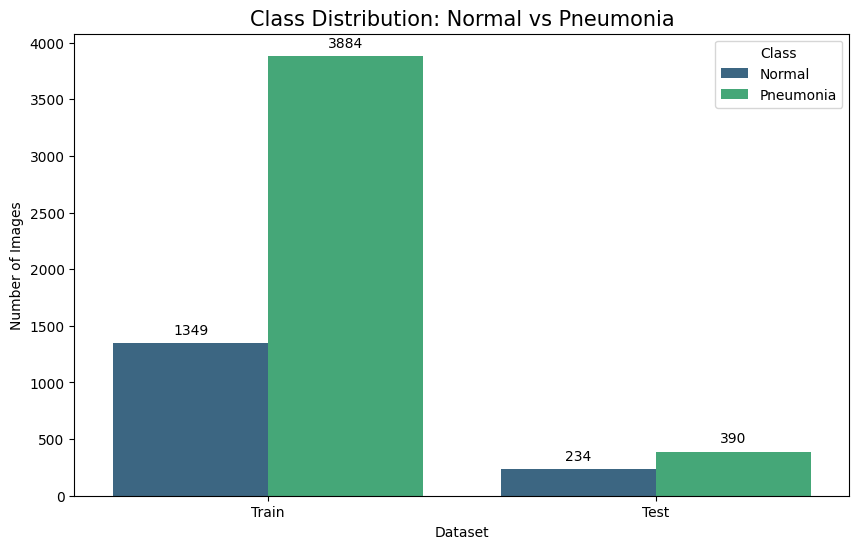

Imbalance Ratio (Pneumonia/Normal) in Train set: 2.88
⚠️ ALERT: Dataset is imbalanced. Recommendation: Use Weighted Loss or Augmentation.
Imbalance Ratio (Pneumonia/Normal) in Test set: 1.67


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a DataFrame for visualization using already computed counts
df_dist = pd.DataFrame({
    'Dataset': ['Train', 'Train', 'Test', 'Test'],
    'Class': ['Normal', 'Pneumonia', 'Normal', 'Pneumonia'],
    'Count': [train_normal, train_pneumonia, test_normal, test_pneumonia]
})

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=df_dist, x='Dataset', y='Count', hue='Class', palette='viridis')
plt.title('Class Distribution: Normal vs Pneumonia', fontsize=15)
plt.ylabel('Number of Images')

# Add text labels on bars
for p in plt.gca().patches:
    if p.get_height() > 0:
        plt.gca().text(p.get_x() + p.get_width()/2, p.get_height() + 50,
                       f'{int(p.get_height())}', ha='center', va='bottom')

plt.show()

# Calculate Imbalance Ratio
# Ensure train_normal is not zero before division
if train_normal > 0:
    train_ratio = train_pneumonia / train_normal
    print(f"Imbalance Ratio (Pneumonia/Normal) in Train set: {train_ratio:.2f}")
    if train_ratio > 1.5:
        print("⚠️ ALERT: Dataset is imbalanced. Recommendation: Use Weighted Loss or Augmentation.")
else:
    print("Cannot calculate Imbalance Ratio for Train set: No Normal images found.")

if test_normal > 0:
    test_ratio = test_pneumonia / test_normal
    print(f"Imbalance Ratio (Pneumonia/Normal) in Test set: {test_ratio:.2f}")
else:
    print("Cannot calculate Imbalance Ratio for Test set: No Normal images found.")

In [ ]:
# Đếm số lượng ảnh
train_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
train_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
total_train = train_normal + train_pneumonia

test_normal = len(os.listdir(os.path.join(test_dir, 'NORMAL')))
test_pneumonia = len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))
total_test = test_normal + test_pneumonia

print(f"\nTrain: NORMAL = {train_normal} pictures (~{train_normal/total_train*100:.1f}%), PNEUMONIA = {train_pneumonia} pictures (~{train_pneumonia/total_train*100:.1f}%)")
print(f"Test: NORMAL = {test_normal} pictures (~{test_normal/total_test*100:.1f}%), PNEUMONIA = {test_pneumonia} pictures (~{test_pneumonia/total_test*100:.1f}%)")
print(f"Total Train: {total_train} pictures | Total Test: {total_test} pictures")


Train: NORMAL = 1349 pictures (~25.8%), PNEUMONIA = 3884 pictures (~74.2%)
Test: NORMAL = 234 pictures (~37.5%), PNEUMONIA = 390 pictures (~62.5%)
Total Train: 5233 pictures | Total Test: 624 pictures


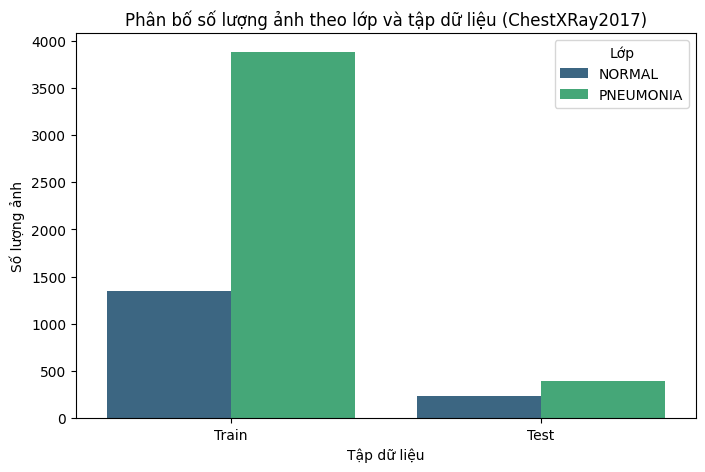

In [ ]:
# 3.1.1 Phân bố số lượng ảnh theo từng lớp (Bar plot)
import matplotlib.pyplot as plt

data = {
    'Tập dữ liệu': ['Train', 'Train', 'Test', 'Test'],
    'Lớp': ['NORMAL', 'PNEUMONIA', 'NORMAL', 'PNEUMONIA'],
    'Số lượng': [train_normal, train_pneumonia, test_normal, test_pneumonia]
}
df = pd.DataFrame(data)

plt.figure(figsize=(8, 5))
sns.barplot(x='Tập dữ liệu', y='Số lượng', hue='Lớp', data=df, palette='viridis')
plt.title('Phân bố số lượng ảnh theo lớp và tập dữ liệu (ChestXRay2017)')
plt.xlabel('Tập dữ liệu')
plt.ylabel('Số lượng ảnh')
plt.legend(title='Lớp')
plt.show()

In [ ]:
# Calculate Imbalance Ratio
train_ratio = train_pneumonia / train_normal
print(f"Imbalance Ratio (Pneumonia/Normal) in Train set: {train_ratio:.2f}")
if train_ratio > 1.5:
    print("⚠️ ALERT: Dataset is imbalanced. Recommendation: Use Weighted Loss or Augmentation.")

Imbalance Ratio (Pneumonia/Normal) in Train set: 2.88
⚠️ ALERT: Dataset is imbalanced. Recommendation: Use Weighted Loss or Augmentation.


b. Kích thước ảnh (Histogram)

Đang phân tích kích thước ảnh...


100%|██████████| 500/500 [02:50<00:00,  2.94it/s]


<Figure size 800x800 with 0 Axes>

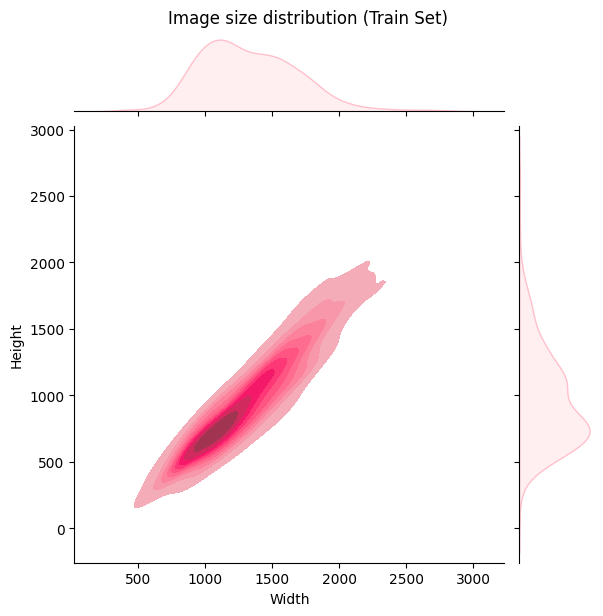

Average Size: 1332x973
Min: [415 140], Max: [2844 2625]


In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

folder_path = train_dir  # Đường dẫn tập train
max_samples = 500       # Số lượng mẫu muốn kiểm tra
all_files = glob.glob(os.path.join(folder_path, '*', '*'))

if len(all_files) > max_samples:
    sampled_files = np.random.choice(all_files, max_samples, replace=False)
else:
    sampled_files = all_files

dims = [] # Khởi tạo dims là một list rỗng
print("Đang phân tích kích thước ảnh...")

for filepath in tqdm(sampled_files):
    try:
        with Image.open(filepath) as img:
            width, height = img.size
            dims.append((width, height))
    except Exception as e:
        print(f"Lỗi đọc file {filepath}: {e}")

df_dims = pd.DataFrame(dims, columns=['Width', 'Height']) # Thêm tên cột

# Jointplot hiển thị cả Scatter (tương quan) và Histogram (phân phối) cùng lúc
plt.figure(figsize=(8, 8))
g = sns.jointplot(data=df_dims, x='Width', y='Height', kind='kde', fill=True, color='pink')
g.fig.suptitle('Image size distribution (Train Set)', y=1.02)
plt.show()

print(f"Average Size: {df_dims['Width'].mean():.0f}x{df_dims['Height'].mean():.0f}")
print(f"Min: {df_dims.min().values}, Max: {df_dims.max().values}")

c. Show sample

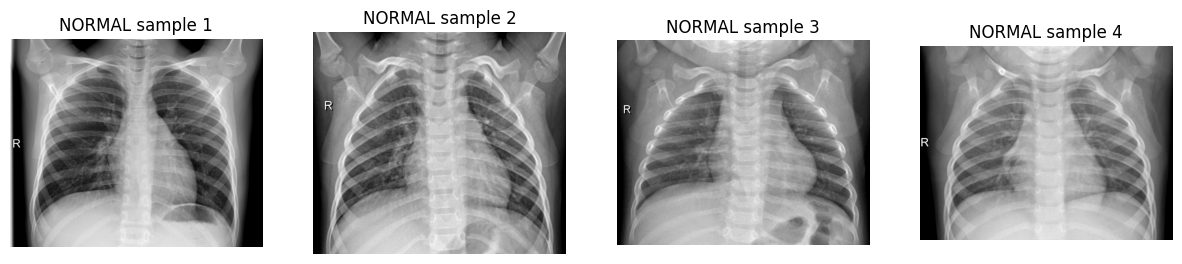

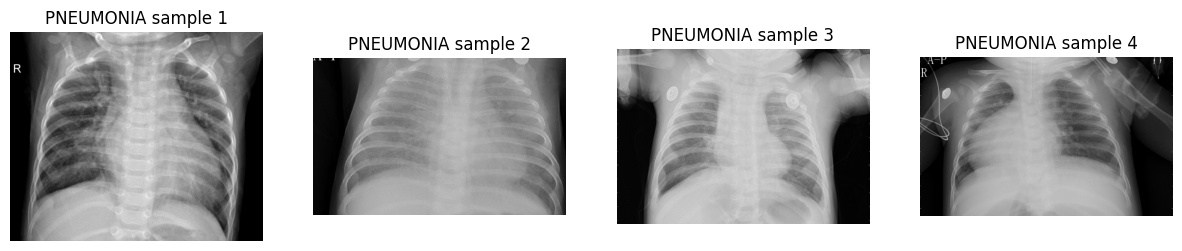

In [ ]:
# 3.1.3 Hiển thị ví dụ ảnh của mỗi lớp (từ train)

def show_samples(folder_path, class_name, num=4):
    path = os.path.join(folder_path, class_name)
    files = os.listdir(path)[:num]
    plt.figure(figsize=(15, 5))
    for i, file in enumerate(files):
        img_path = os.path.join(path, file)
        img = Image.open(img_path)
        plt.subplot(1, num, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(f"{class_name} sample {i+1}")
        plt.axis('off')
    plt.show()

# Hiển thị
show_samples(train_dir, 'NORMAL')
show_samples(train_dir, 'PNEUMONIA')

**d. Pixel Intensity Distribution**

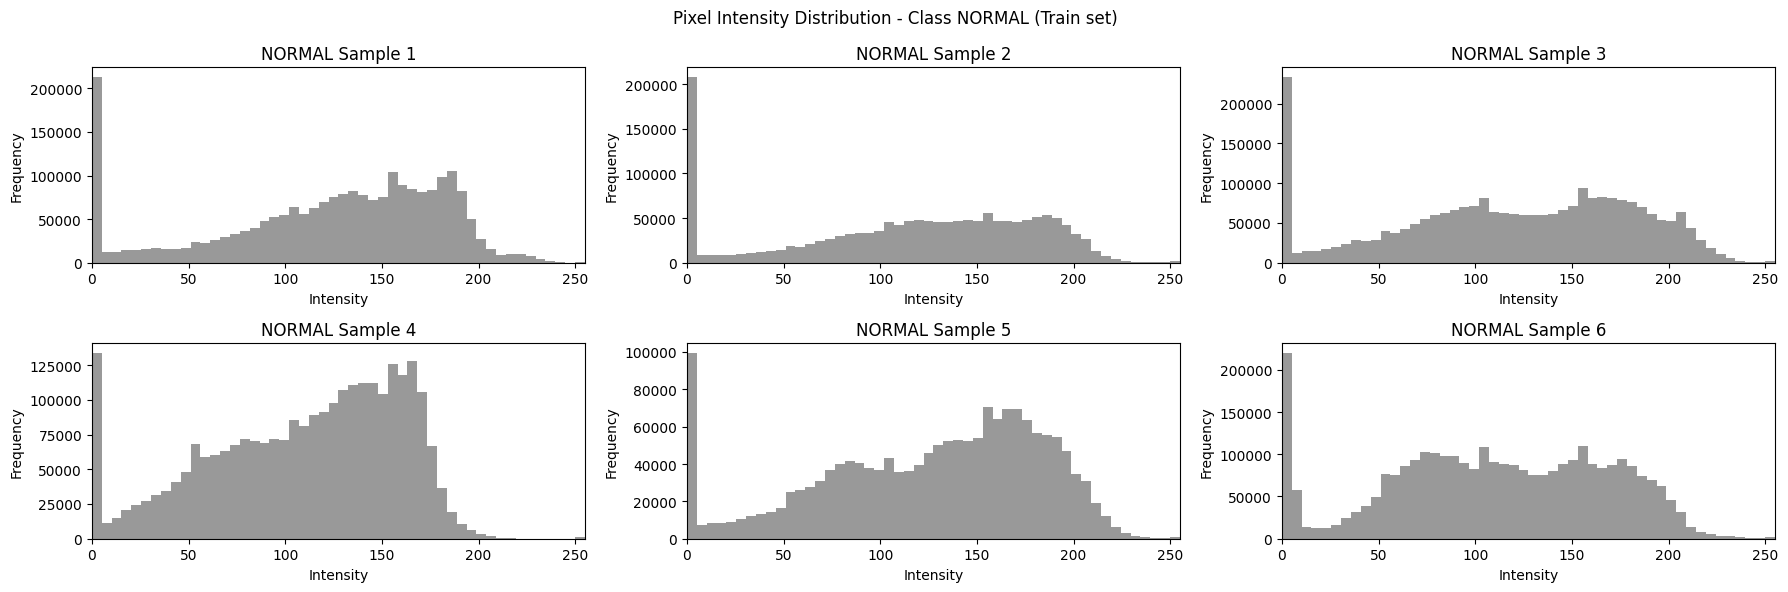

Class NORMAL: Mean intensity = 115.77, Std = 58.80


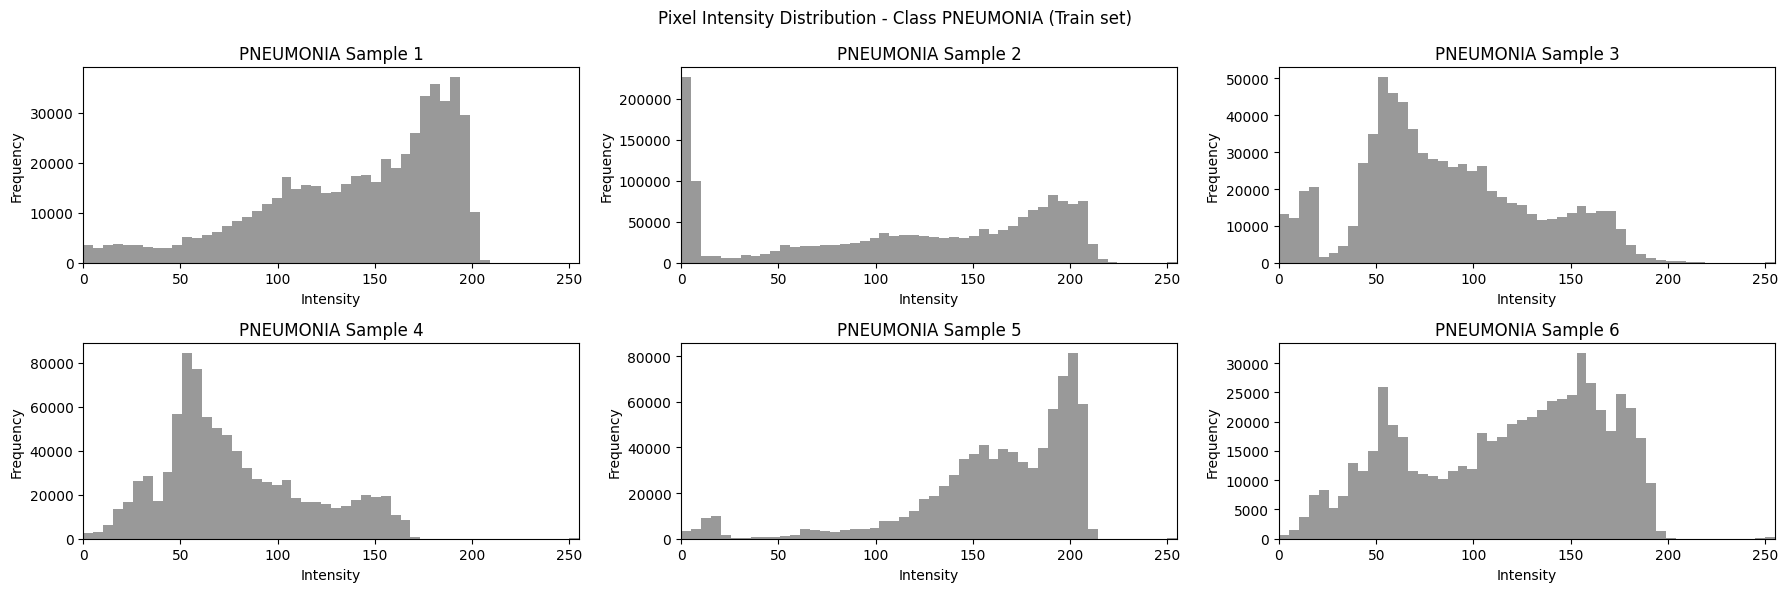

Class PNEUMONIA: Mean intensity = 114.74, Std = 61.45


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random

def plot_pixel_intensity(folder_path, class_name, num_samples=6):
    path = os.path.join(folder_path, class_name)
    if not os.path.exists(path):
        print(f"Không tìm thấy thư mục {class_name}!")
        return

    files = random.sample(os.listdir(path), min(num_samples, len(os.listdir(path))))

    plt.figure(figsize=(18, 6))
    all_pixels = []  # Để tính thống kê tổng

    for i, file in enumerate(files):
        img_path = os.path.join(path, file)
        img = Image.open(img_path).convert('L')  # Grayscale
        pixel_data = np.array(img).flatten()
        all_pixels.extend(pixel_data)

        plt.subplot(2, num_samples//2, i+1)
        plt.hist(pixel_data, bins=50, color='gray', alpha=0.8, range=(0, 255))
        plt.title(f'{class_name} Sample {i+1}')
        plt.xlabel('Intensity')
        plt.ylabel('Frequency')
        plt.xlim(0, 255)

    plt.suptitle(f'Pixel Intensity Distribution - Class {class_name} (Train set)')
    plt.tight_layout()
    plt.show()

    # Thống kê tổng
    mean_int = np.mean(all_pixels)
    std_int = np.std(all_pixels)
    print(f"Class {class_name}: Mean intensity = {mean_int:.2f}, Std = {std_int:.2f}")

# Chạy cho cả hai lớp
plot_pixel_intensity(train_dir, 'NORMAL')
plot_pixel_intensity(train_dir, 'PNEUMONIA')

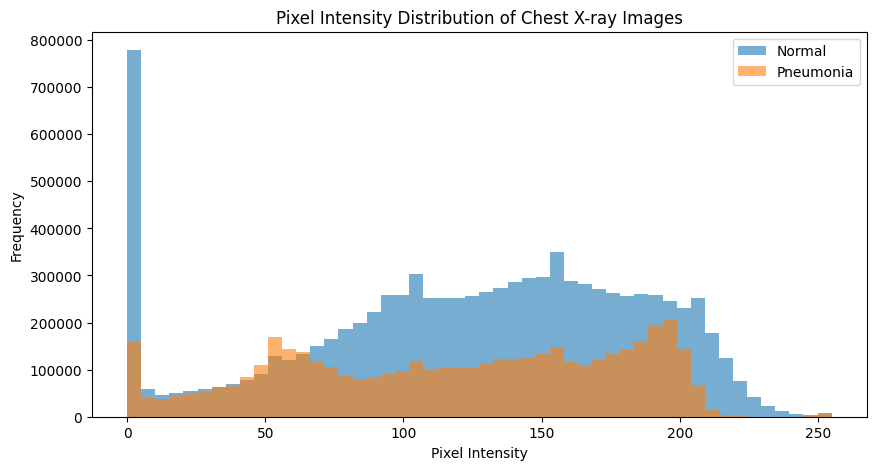

In [ ]:
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt

# Sử dụng biến train_dir đã được định nghĩa trước đó
normal_dir = os.path.join(train_dir, 'NORMAL')
pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')

normal_imgs = random.sample(os.listdir(normal_dir), 5)
pneumonia_imgs = random.sample(os.listdir(pneumonia_dir), 5)

def load_pixels(img_list, folder):
    pixels = []
    for img in img_list:
        path = os.path.join(folder, img)
        image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        pixels.extend(image.flatten())
    return pixels

normal_pixels = load_pixels(normal_imgs, normal_dir)
pneumonia_pixels = load_pixels(pneumonia_imgs, pneumonia_dir)

plt.figure(figsize=(10,5))

plt.hist(normal_pixels, bins=50, alpha=0.6, label='Normal')
plt.hist(pneumonia_pixels, bins=50, alpha=0.6, label='Pneumonia')

plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.title("Pixel Intensity Distribution of Chest X-ray Images")
plt.legend()
plt.show()

**2. Preprocessing**

In [ ]:
# 2. Định nghĩa kích thước ảnh cho từng model
IMG_SIZE_RESNET = (224, 224)   # Cho ResNet50 và Hybrid ResNet50 + ViT
IMG_SIZE_ALEXNET = (227, 227)  # Cho AlexNet tự build

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 3. Data Augmentation (chỉ áp dụng cho TRAIN set)
# ───────────────────────────────────────────────────────────────
train_datagen = ImageDataGenerator(
    rescale=1./255,                        # Normalize [0,1]
    rotation_range=20,                     # Rotation ±20°
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Val và Test chỉ normalize, KHÔNG augment
val_test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# 4. Tạo Generators với Resize + Normalize + Augmentation
# ───────────────────────────────────────────────────────────────
# Dùng grayscale gốc, sau đó convert RGB trong model

batch_size = 8

# Generator cho ResNet50 / Hybrid (224x224)
train_gen_resnet = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE_RESNET,
    color_mode='grayscale',          # Giữ grayscale ban đầu
    class_mode='binary',
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

test_gen_resnet = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE_RESNET,
    color_mode='grayscale',
    class_mode='binary',
    batch_size=batch_size,
    shuffle=False
)

# Generator riêng cho AlexNet (227x227) nếu cần
train_gen_alexnet = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE_ALEXNET,
    color_mode='grayscale',
    class_mode='binary',
    batch_size=batch_size,
    shuffle=True,
    seed=42
)

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 5232 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras.applications import ResNet50

# 5. Convert grayscale to 3-channel RGB (dùng Lambda layer trong model)
# ───────────────────────────────────────────────────────────────
# Hàm này có thể dùng cho mọi model pretrained (ResNet50, ViT hybrid)
def add_grayscale_to_rgb_conversion():
    inputs = Input(shape=(224, 224, 1))  # Input grayscale sau generator
    # Repeat channel 3 lần để thành RGB
    rgb_output = Lambda(lambda x: tf.repeat(x, repeats=3, axis=-1))(inputs)
    return inputs, rgb_output

# Ví dụ sử dụng trong model ResNet50

# Tạo base model ResNet50 (weights ImageNet yêu cầu RGB)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Thêm layer conversion
inputs, rgb_converted = add_grayscale_to_rgb_conversion()
model_output = base_model(rgb_converted)  # Truyền RGB vào base

print("Layer conversion grayscale → RGB đã thêm thành công!")
print("Input shape:", inputs.shape)
print("Sau conversion:", rgb_converted.shape)  # (None, 224, 224, 3)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Layer conversion grayscale → RGB đã thêm thành công!
Input shape: (None, 224, 224, 1)
Sau conversion: (None, 224, 224, 3)


Check preprocess

In [ ]:
# 6. Kiểm tra kết quả preprocessing (xem sample batch)
# ───────────────────────────────────────────────────────────────
# Lấy một batch từ train_gen_resnet
x_batch, y_batch = next(train_gen_resnet)

print("\nBatch shape after Resize + Normalize + Augmentation:", x_batch.shape)
# Kết quả: (32, 224, 224, 1) - grayscale đã normalize [0,1]

# Nếu muốn xem RGB conversion hoạt động (simulate)
rgb_simulated = np.repeat(x_batch[:1], 3, axis=-1)  # Lấy 1 ảnh đầu
print("RGB simulated shape:", rgb_simulated.shape)  # (1, 224, 224, 3)


Batch shape after Resize + Normalize + Augmentation: (8, 224, 224, 1)
RGB simulated shape: (1, 224, 224, 3)


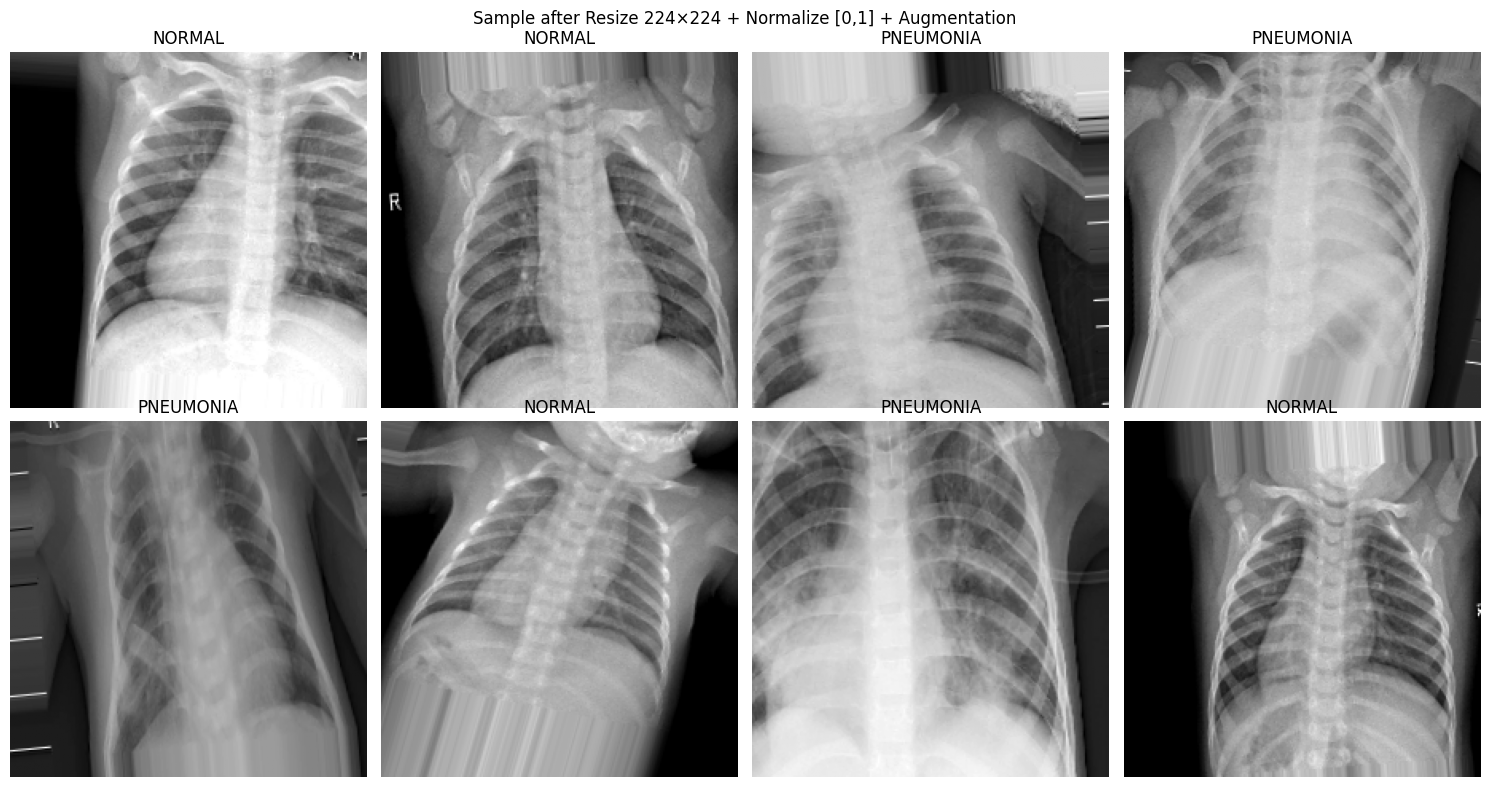

In [ ]:
# Visualize 8 ảnh mẫu sau preprocessing
plt.figure(figsize=(15, 8))
for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.imshow(x_batch[i].squeeze(), cmap='gray')  # squeeze để bỏ channel 1
    label = 'PNEUMONIA' if y_batch[i] == 1 else 'NORMAL'
    plt.title(f"{label}")
    plt.axis('off')

plt.suptitle('Sample after Resize 224×224 + Normalize [0,1] + Augmentation')
plt.tight_layout()
plt.show()

In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Định nghĩa đường dẫn
train_dir = '/content/drive/MyDrive/Datasets/chest_xray/train'
test_dir = '/content/drive/MyDrive/Datasets/chest_xray/test'

# 2. Cấu hình Augmentation (Theo mục 4.3 Outline)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

# 3. Tạo Generators (Lưu ý: Bỏ grayscale để dùng RGB mặc định cho 3 model)
print("--- Khởi tạo Data Generators ---")
train_gen_alexnet = train_datagen.flow_from_directory(
    train_dir, target_size=(227, 227), batch_size=32, class_mode='binary')

test_gen_alexnet = test_datagen.flow_from_directory(
    test_dir, target_size=(227, 227), batch_size=32, class_mode='binary', shuffle=False)

train_gen_resnet = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=16, class_mode='binary')

test_gen_resnet = test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=16, class_mode='binary', shuffle=False)

--- Khởi tạo Data Generators ---
Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate, MultiHeadAttention

# --- AlexNet Architecture (Model 1) ---
def build_alexnet(input_shape):
    model = models.Sequential([
        layers.Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((3, 3), strides=(2, 2)),
        layers.BatchNormalization(),
        layers.Conv2D(256, (5, 5), padding='same', activation='relu'),
        layers.MaxPooling2D((3, 3), strides=(2, 2)),
        layers.BatchNormalization(),
        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(384, (3, 3), padding='same', activation='relu'),
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.MaxPooling2D((3, 3), strides=(2, 2)),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(4096, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid') # Binary classification
    ])
    return model


# --- ResNet50 Transfer Learning Architecture (Model 2) ---
def build_resnet50_tl(input_shape):
    # Load ResNet50 pre-trained on ImageNet, without the top classification layer
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom classification head
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    predictions = layers.Dense(1, activation='sigmoid')(x) # Binary classification

    model = models.Model(inputs=base_model.input, outputs=predictions)
    return model


# --- Hybrid ResNet + ViT Ultra-Light Architecture (Model 3) ---
def build_hybrid_resnet_vit_ultra_light(input_shape):
    # 1. ResNet50 Feature Extractor (Pre-trained)
    base_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_resnet.layers:
        layer.trainable = False  # Freeze ResNet base

    # 2. Patch Embedding (Simplified ViT part)
    # We'll use a Conv layer to mimic patch embedding + positional encoding
    # Input shape for ViT part will be the output of ResNet50
    # ResNet50 output for (224,224,3) input is (7,7,2048) or (1x1x2048) after GlobalAvgPooling

    resnet_output = base_resnet.output # Output is (batch_size, 7, 7, 2048)

    # Flatten the spatial dimensions to treat features as 'tokens'
    # Reshape (7,7,2048) -> (49, 2048)
    num_patches = resnet_output.shape[1] * resnet_output.shape[2]
    patch_dim = resnet_output.shape[3]
    x = layers.Reshape((num_patches, patch_dim))(resnet_output) # (batch_size, 49, 2048)

    # Add a learnable positional embedding (simple way)
    position_embedding = tf.Variable(tf.random.normal([1, num_patches, patch_dim]), trainable=True)
    x = x + position_embedding

    # 3. Transformer Block (Ultra-light: 1 MultiHeadAttention layer)
    # Using a reduced number of heads and a smaller key_dim for 'ultra-light'
    attention_output = MultiHeadAttention(num_heads=4, key_dim=64, dropout=0.1)(
        x, x, x # Query, Key, Value are all from the same input for self-attention
    )

    # Global Average Pooling on the attention output (across patches)
    x = layers.GlobalAveragePooling1D()(attention_output) # (batch_size, patch_dim)

    # 4. Classification Head
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    predictions = layers.Dense(1, activation='sigmoid')(x) # Binary classification

    model = models.Model(inputs=base_resnet.input, outputs=predictions)
    return model

print("Đã định nghĩa các hàm build_alexnet, build_resnet50_tl, build_hybrid_resnet_vit_ultra_light")

Đã định nghĩa các hàm build_alexnet, build_resnet50_tl, build_hybrid_resnet_vit_ultra_light


In [ ]:
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 1. Thiết lập Callbacks (End sớm)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1)
]

# Trọng số lớp (Xử lý mất cân bằng dữ liệu)
class_weights = {0: 1.94, 1: 0.67}

# --- HUẤN LUYỆN MODEL 1: ALEXNET ---
print("\n--- ĐANG HUẤN LUYỆN MODEL 1: ALEXNET ---")
model_alex = build_alexnet(input_shape=(227, 227, 3))
model_alex.compile(optimizer=optimizers.Adam(0.001), loss='binary_crossentropy',
                   metrics=['accuracy', tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.Precision(name='precision')])
history_alex = model_alex.fit(train_gen_alexnet, validation_data=test_gen_alexnet,
                              epochs=50, class_weight=class_weights, callbacks=callbacks)

# --- HUẤN LUYỆN MODEL 2: RESNET50 ---
print("\n--- ĐANG HUẤN LUYỆN MODEL 2: RESNET50 ---")
model_res = build_resnet50_tl(input_shape=(224, 224, 3))
model_res.compile(optimizer=optimizers.Adam(0.001), loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.Precision(name='precision')])
history_res = model_res.fit(train_gen_resnet, validation_data=test_gen_resnet,
                            epochs=50, class_weight=class_weights, callbacks=callbacks)

# --- HUẤN LUYỆN MODEL 3: HYBRID ---
print("\n--- ĐANG HUẤN LUYỆN MODEL 3: HYBRID ---")
model_hybrid = build_hybrid_resnet_vit_ultra_light(input_shape=(224, 224, 3))
model_hybrid.compile(optimizer=optimizers.Adam(1e-4), loss='binary_crossentropy',
                      metrics=['accuracy', tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.Precision(name='precision')])
history_hybrid = model_hybrid.fit(train_gen_resnet, validation_data=test_gen_resnet,
                                 epochs=50, class_weight=class_weights, callbacks=callbacks)


--- ĐANG HUẤN LUYỆN MODEL 1: ALEXNET ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 582s 3s/step - accuracy: 0.7113 - loss: 3.0626 - precision: 0.8652 - recall: 0.7147 - val_accuracy: 0.6250 - val_loss: 7.7254 - val_precision: 0.6250 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 128s 777ms/step - accuracy: 0.8534 - loss: 0.3567 - precision: 0.9505 - recall: 0.8485 - val_accuracy: 0.4263 - val_loss: 0.8445 - val_precision: 0.9706 - val_recall: 0.0846 - learning_rate: 0.0010
Epoch 3/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 127s 777ms/step - accuracy: 0.8714 - loss: 0.3002 - precision: 0.9666 - recall: 0.8568 - val_accuracy: 0.6250 - val_loss: 8.3276 - val_precision: 0.6250 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 125s 765ms/step - accuracy: 0.8769 - loss: 0.2908 - precision: 0.9605 - recall: 0.8694 - val_accuracy: 0.6250 - val_loss: 4.5654 - val_precision: 0.6250 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 126s 767ms/

               Model Val Accuracy Val Recall
0            AlexNet       90.71%     94.62%
1           ResNet50       78.37%     73.85%
2  Hybrid (Proposed)       79.81%     78.21%
39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step


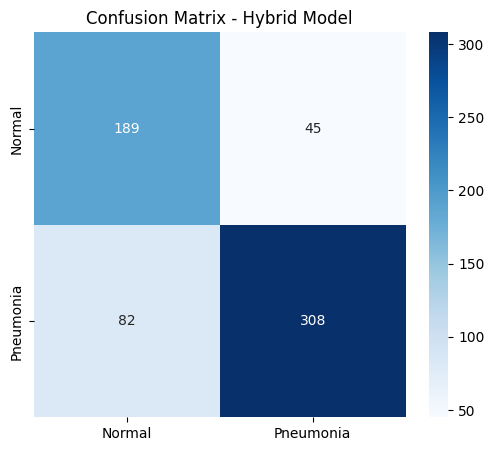


Detailed Report for Hybrid Model:
              precision    recall  f1-score   support

      Normal       0.70      0.81      0.75       234
   Pneumonia       0.87      0.79      0.83       390

    accuracy                           0.80       624
   macro avg       0.78      0.80      0.79       624
weighted avg       0.81      0.80      0.80       624



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 1. Bảng so sánh Accuracy/Recall
def get_metrics(history, name):
    return [name, f"{history.history['val_accuracy'][-1]:.2%}", f"{history.history['val_recall'][-1]:.2%}"]

data = [get_metrics(history_alex, "AlexNet"),
        get_metrics(history_res, "ResNet50"),
        get_metrics(history_hybrid, "Hybrid (Proposed)")]
df_results = pd.DataFrame(data, columns=["Model", "Val Accuracy", "Val Recall"])
print(df_results)

# 2. Vẽ Confusion Matrix cho Model Hybrid (Thường là model tốt nhất)
test_gen_resnet.reset()
y_pred_prob = model_hybrid.predict(test_gen_resnet)
y_pred = (y_pred_prob > 0.5).astype(int)
y_true = test_gen_resnet.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.title('Confusion Matrix - Hybrid Model')
plt.show()

print("\nDetailed Report for Hybrid Model:")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))

--- BẢNG SO SÁNH KẾT QUẢ ĐỊNH LƯỢNG ---
| Model               | Accuracy   | Precision   | Recall   |
|:--------------------|:-----------|:------------|:---------|
| AlexNet (Baseline)  | 90.71%     | 90.89%      | 94.62%   |
| ResNet50 (Transfer) | 78.37%     | 89.72%      | 73.85%   |
| Hybrid ResNet+ViT   | 79.81%     | 88.15%      | 78.21%   |


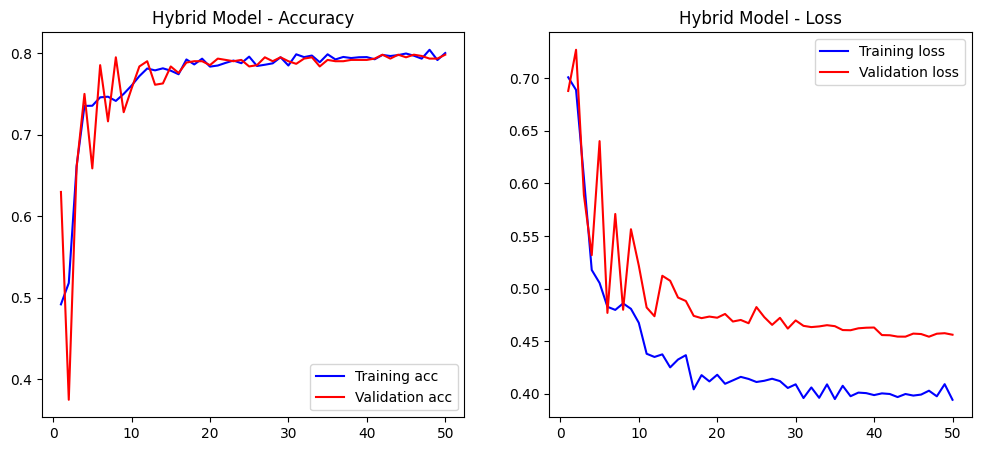

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def get_final_metrics(history, name):
    acc = history.history['val_accuracy'][-1]
    recall = history.history['val_recall'][-1]
    precision = history.history['val_precision'][-1]
    return [name, f"{acc:.2%}", f"{precision:.2%}", f"{recall:.2%}"]

# 1. Hiển thị bảng so sánh
results = [
    get_final_metrics(history_alex, "AlexNet (Baseline)"),
    get_final_metrics(history_res, "ResNet50 (Transfer)"),
    get_final_metrics(history_hybrid, "Hybrid ResNet+ViT")
]
df_compare = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall"])
print("--- BẢNG SO SÁNH KẾT QUẢ ĐỊNH LƯỢNG ---")
print(df_compare.to_markdown(index=False))

# 2. Định nghĩa hàm vẽ đồ thị (Dùng chung cho các phần dưới)
def plot_history(history, title="Model Training"):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title(f'{title} - Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'{title} - Loss')
    plt.legend()
    plt.show()

# Vẽ đồ thị cho Model Hybrid (Nhân vật chính)
plot_history(history_hybrid, title="Hybrid Model")

39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 188ms/step


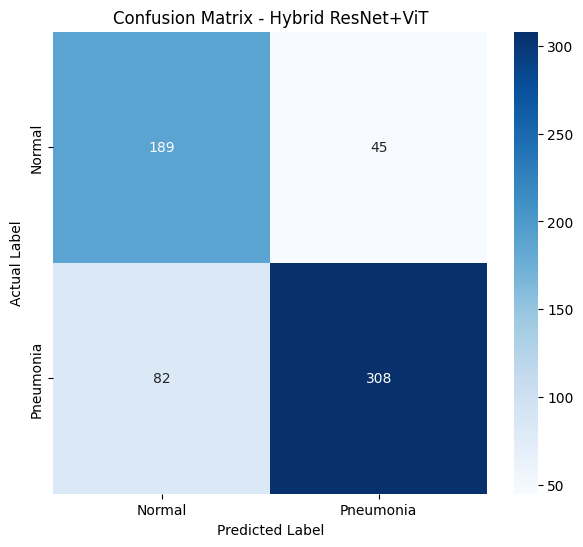


BÁO CÁO CHI TIẾT (CLASSIFICATION REPORT):
              precision    recall  f1-score   support

      Normal       0.70      0.81      0.75       234
   Pneumonia       0.87      0.79      0.83       390

    accuracy                           0.80       624
   macro avg       0.78      0.80      0.79       624
weighted avg       0.81      0.80      0.80       624


Tổng số ca dự đoán sai: 127/624


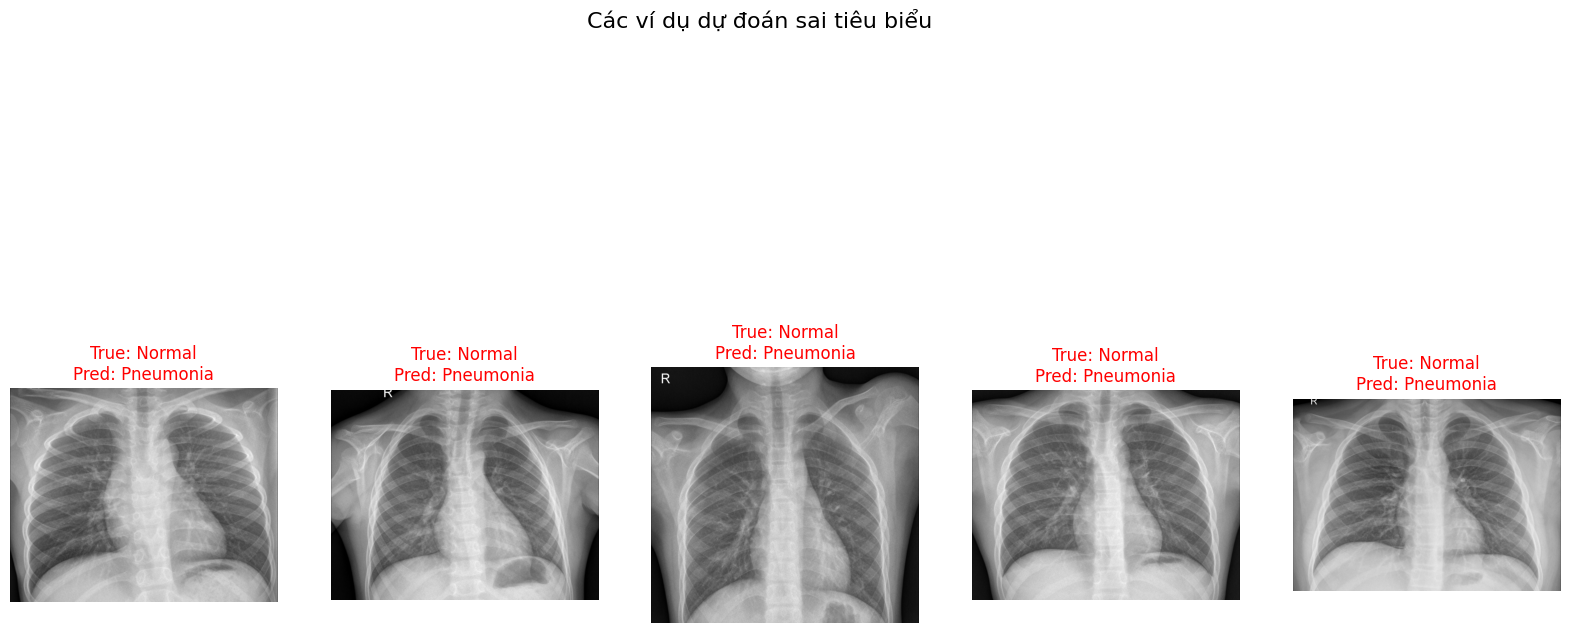

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

# 1. Lấy dự đoán từ model Hybrid
test_gen_resnet.reset()
y_pred_prob = model_hybrid.predict(test_gen_resnet)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()
y_true = test_gen_resnet.classes
filenames = test_gen_resnet.filenames

# 2. Vẽ Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Pneumonia'],
            yticklabels=['Normal', 'Pneumonia'])
plt.title('Confusion Matrix - Hybrid ResNet+ViT')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# 3. In báo cáo chi tiết
print("\nBÁO CÁO CHI TIẾT (CLASSIFICATION REPORT):")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))

# 4. Hiển thị ảnh dự đoán sai (Mục 8.3)
errors = np.where(y_pred != y_true)[0]
print(f"\nTổng số ca dự đoán sai: {len(errors)}/{len(y_true)}")

if len(errors) > 0:
    plt.figure(figsize=(20, 10))
    num_show = min(5, len(errors))
    for i, idx in enumerate(errors[:num_show]):
        plt.subplot(1, 5, i + 1)
        img_path = os.path.join(test_dir, filenames[idx])
        img = plt.imread(img_path)
        plt.imshow(img, cmap='gray')
        label_true = "Pneumonia" if y_true[idx] == 1 else "Normal"
        label_pred = "Pneumonia" if y_pred[idx] == 1 else "Normal"
        plt.title(f"True: {label_true}\nPred: {label_pred}", color='red')
        plt.axis('off')
    plt.suptitle("Các ví dụ dự đoán sai tiêu biểu", fontsize=16)
    plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 354ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 165ms/step


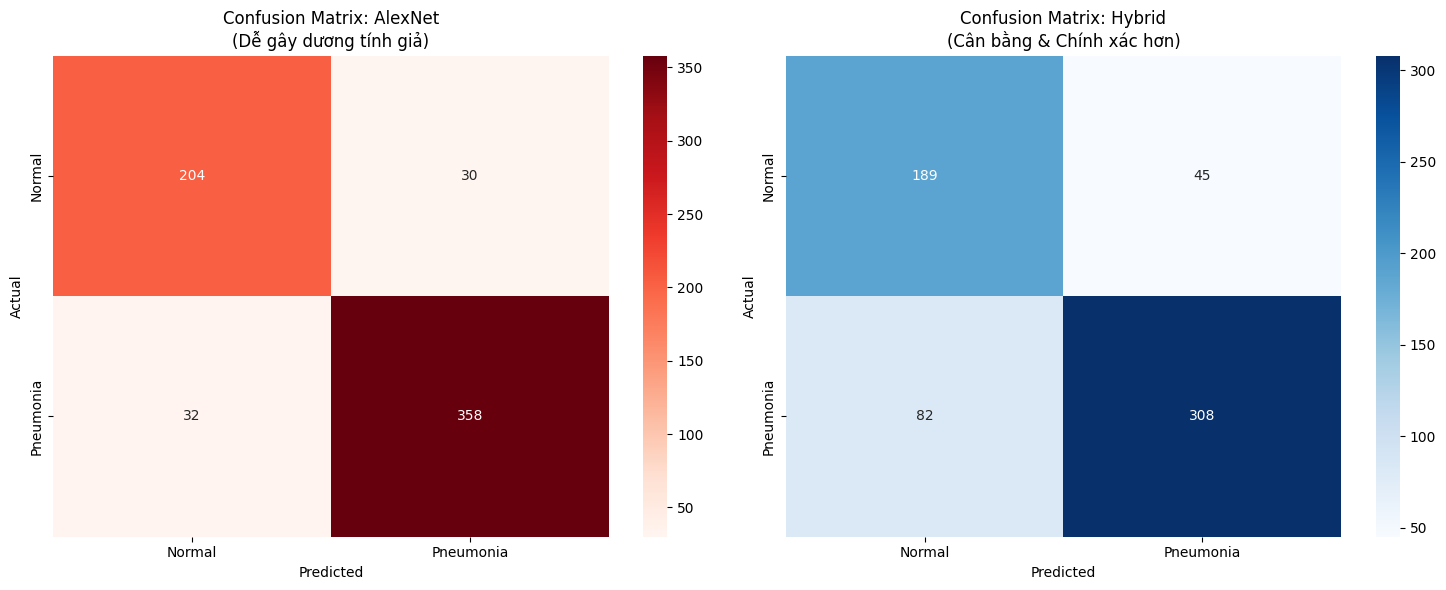

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_dual_confusion_matrix(model_a, gen_a, model_b, gen_b, name_a="AlexNet", name_b="Hybrid"):
    # 1. Lấy dự đoán của Model A
    gen_a.reset()
    y_pred_a = (model_a.predict(gen_a) > 0.5).astype(int).flatten()
    y_true_a = gen_a.classes
    cm_a = confusion_matrix(y_true_a, y_pred_a)

    # 2. Lấy dự đoán của Model B
    gen_b.reset()
    y_pred_b = (model_b.predict(gen_b) > 0.5).astype(int).flatten()
    y_true_b = gen_b.classes
    cm_b = confusion_matrix(y_true_b, y_pred_b)

    # 3. Vẽ biểu đồ
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    labels = ['Normal', 'Pneumonia']

    # Vẽ cho Model A
    sns.heatmap(cm_a, annot=True, fmt='d', cmap='Reds', ax=ax1, xticklabels=labels, yticklabels=labels)
    ax1.set_title(f'Confusion Matrix: {name_a}\n(Dễ gây dương tính giả)')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')

    # Vẽ cho Model B
    sns.heatmap(cm_b, annot=True, fmt='d', cmap='Blues', ax=ax2, xticklabels=labels, yticklabels=labels)
    ax2.set_title(f'Confusion Matrix: {name_b}\n(Cân bằng & Chính xác hơn)')
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

# Gọi hàm để vẽ
plot_dual_confusion_matrix(model_alex, test_gen_alexnet, model_hybrid, test_gen_resnet)

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 290ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 157ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 195ms/step


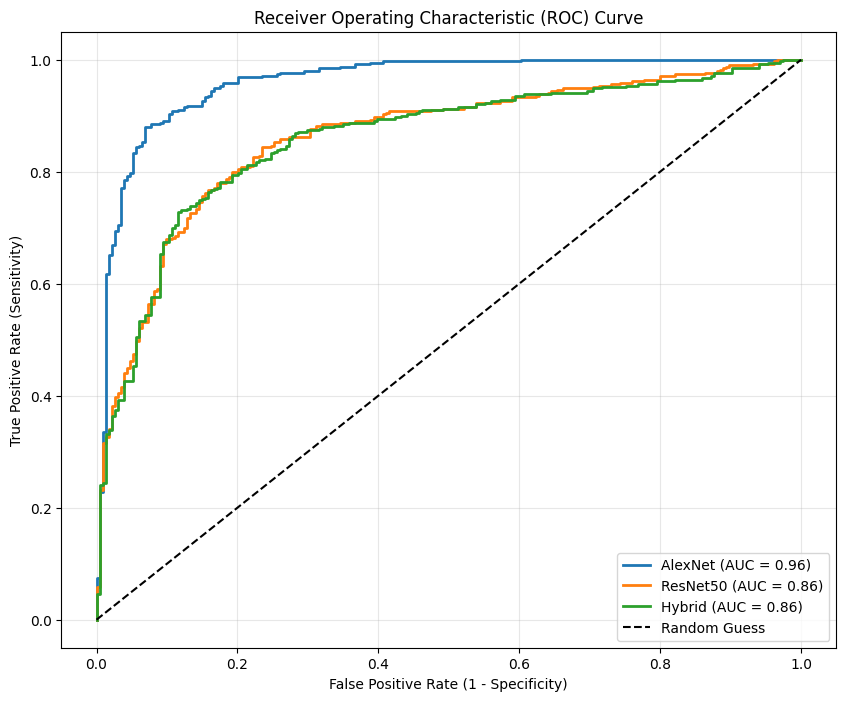

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(models_dict, generators_dict):
    plt.figure(figsize=(10, 8))
    for name, model in models_dict.items():
        gen = generators_dict[name]
        gen.reset()
        y_pred_prob = model.predict(gen).flatten()
        y_true = gen.classes
        fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})', linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()

# Thực thi vẽ ROC
models_to_compare = {'AlexNet': model_alex, 'ResNet50': model_res, 'Hybrid': model_hybrid}
gens_to_compare = {'AlexNet': test_gen_alexnet, 'ResNet50': test_gen_resnet, 'Hybrid': test_gen_resnet}
plot_roc_curve(models_to_compare, gens_to_compare)

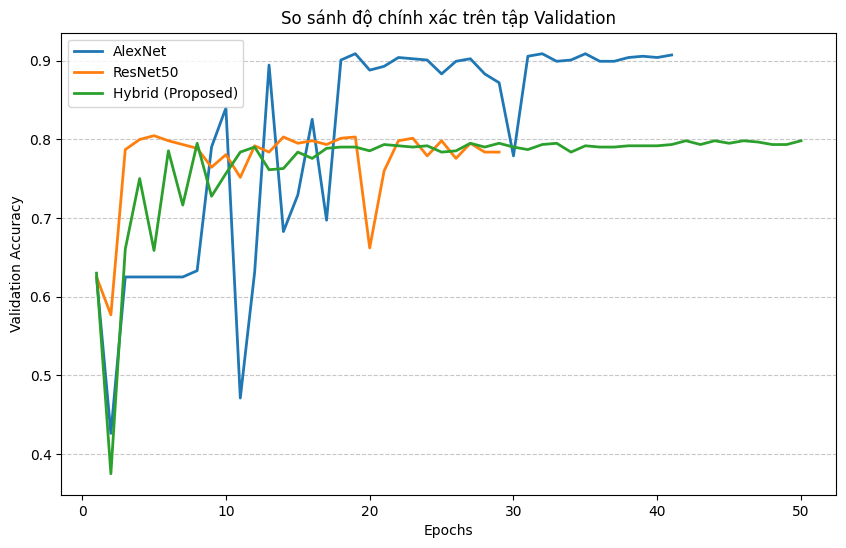

In [ ]:
def plot_compare_history(histories, title="So sánh độ chính xác trên tập Validation"):
    plt.figure(figsize=(10, 6))
    for name, history in histories.items():
        val_acc = history.history['val_accuracy']
        plt.plot(range(1, len(val_acc) + 1), val_acc, label=f'{name}', linewidth=2)

    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Validation Accuracy')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Thực thi vẽ so sánh hội tụ
history_dict = {
    'AlexNet': history_alex,
    'ResNet50': history_res,
    'Hybrid (Proposed)': history_hybrid
}
plot_compare_history(history_dict)

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_377']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


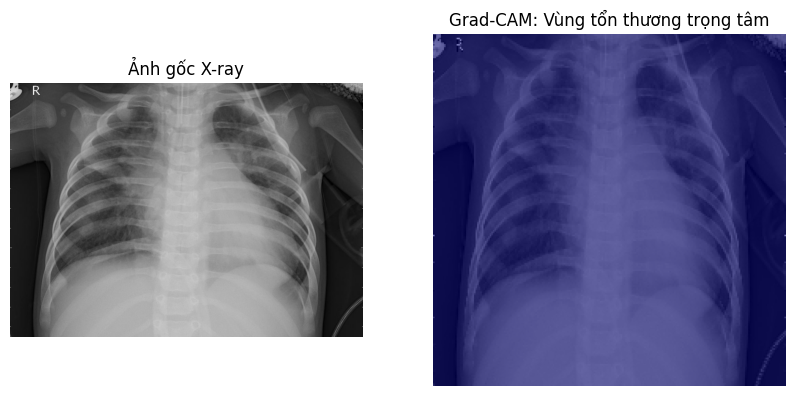

In [ ]:
import cv2
import tensorflow as tf

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # Tạo mô hình bản đồ hóa đặc trưng
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # Tính đạo hàm của lớp dự đoán so với bản đồ đặc trưng
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Chuẩn hóa Heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Thực thi Grad-CAM cho 1 ảnh Pneumonia ngẫu nhiên từ tập test
img_path = test_dir + "/PNEUMONIA/" + os.listdir(test_dir + "/PNEUMONIA/")[0]
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))
img_tensor = np.expand_dims(img, axis=0) / 255.0

# Lưu ý: 'conv5_block3_out' là tên lớp conv cuối của ResNet50
heatmap = make_gradcam_heatmap(img_tensor, model_hybrid, "conv5_block3_out")

# Hiển thị
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
plt.title("Ảnh gốc X-ray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img)
plt.imshow(cv2.resize(heatmap, (224, 224)), cmap='jet', alpha=0.5)
plt.title("Grad-CAM: Vùng tổn thương trọng tâm")
plt.axis('off')
plt.show()

In [ ]:
# Lưu mô hình tốt nhất (Hybrid)
model_hybrid.save('best_hybrid_pneumonia_model.keras')

# (Tùy chọn) Nếu bạn muốn lưu cả 2 mô hình kia để so sánh sau này:
model_alex.save('alexnet_baseline.keras')
model_res.save('resnet50_transfer.keras')

print("--- Đã lưu tất cả các mô hình thành công! ---")

--- Đã lưu tất cả các mô hình thành công! ---


In [ ]:
import os
print("Current working directory:", os.getcwd())


Current working directory: /content


In [ ]:
import os
os.listdir(".")


['.config', 'drive', 'sample_data']

In [ ]:
import os

os.listdir("/content/drive/MyDrive/AI_Models")



FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/AI_Models'

In [ ]:
from google.colab import files

files.download('best_hybrid_pneumonia_model.keras')
files.download('alexnet_baseline.keras')
files.download('resnet50_transfer.keras')


FileNotFoundError: Cannot find file: best_hybrid_pneumonia_model.keras

In [ ]:
import gradio as gr
import tensorflow as tf
import numpy as np
import cv2
from PIL import Image
import uuid
from datetime import datetime

# =========================================================
# 1. LOAD MODEL
# =========================================================
import os
import tensorflow as tf

# =========================================================
# SAFE MODEL LOADER (DEPLOY READY)
# =========================================================

MODEL_CANDIDATES = [
    "best_hybrid_pneumonia_model.keras",
    "hybrid_pneumonia_model.keras",
    "alexnet_baseline.keras",
    "resnet50_transfer.keras",

    # Phòng trường hợp chạy Colab + Drive
    "/content/drive/MyDrive/best_hybrid_pneumonia_model.keras",
    "/content/drive/MyDrive/hybrid_pneumonia_model.keras",
]

model = None
loaded_path = None

print("📂 Current working directory:", os.getcwd())
print("📁 Available files:", os.listdir(os.getcwd()))

for path in MODEL_CANDIDATES:
    try:
        if os.path.exists(path):
            print(f"🔍 Found model file: {path}")
            model = tf.keras.models.load_model(
                path,
                compile=False   # 👈 tránh lỗi custom objects
            )
            loaded_path = path
            print(f"✅ Model loaded successfully from: {path}")
            break
    except Exception as e:
        print(f"⚠️ Failed to load {path}: {e}")

if model is None:
    raise RuntimeError(
        "❌ No trained model could be loaded.\n"
        "👉 Please ensure at least one `.keras` model exists and is accessible.\n"
        "👉 Suggested fix: model_hybrid.save('best_hybrid_pneumonia_model.keras')"
    )

# Optional: compile lại sau khi load
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

print(f"🚀 Model ready for inference (source: {loaded_path})")



# =========================================================
# 2. GRAD-CAM
# =========================================================
def make_gradcam_heatmap(img_array, model, last_conv_layer_name="conv5_block3_out"):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-10)

    return heatmap.numpy()

# =========================================================
# 3. DIAGNOSTIC PIPELINE
# =========================================================
def diagnostic_pipeline(img, show_heatmap):
    if img is None:
        return None, None, "<div>Please upload an image.</div>", None, None, None

    # --- Metadata ---
    patient_id = f"CASE-{uuid.uuid4().hex[:8].upper()}"
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    # --- Preprocess ---
    orig_img = np.array(img.convert("RGB"))
    resized = img.resize((224, 224)).convert("RGB")
    img_array = np.array(resized) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # --- Prediction ---
    prob = float(model.predict(img_array)[0][0])
    is_pneumonia = prob >= 0.5
    confidence = prob if is_pneumonia else (1 - prob)

    # --- Risk Level ---
    if confidence < 0.6:
        risk = "LOW"
        risk_color = "#22c55e"
    elif confidence < 0.85:
        risk = "MEDIUM"
        risk_color = "#facc15"
    else:
        risk = "HIGH"
        risk_color = "#ef4444"

    label = "PNEUMONIA DETECTED" if is_pneumonia else "NORMAL"

    # --- Grad-CAM ---
    gradcam_img = orig_img.copy()
    if show_heatmap:
        heatmap = make_gradcam_heatmap(img_array, model)
        heatmap = cv2.resize(heatmap, (orig_img.shape[1], orig_img.shape[0]))
        heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_HOT)
        gradcam_img = cv2.addWeighted(orig_img, 0.45, heatmap, 0.55, 0)

    # --- Result Card ---
    status_html = f"""
    <div style="
        background:#020617;
        border-left:8px solid {risk_color};
        padding:20px;
        border-radius:14px;
        box-shadow:0 10px 30px rgba(0,0,0,0.4);
        color:white;
        ">
        <h2 style="margin:0;color:{risk_color};">{label}</h2>
        <p><b>Confidence:</b> {confidence*100:.2f}%</p>
        <p><b>Risk Level:</b> <span style="color:{risk_color};font-weight:700;">{risk}</span></p>
        <hr>
        <p><b>Patient ID:</b> {patient_id}</p>
        <p><b>Timestamp:</b> {timestamp}</p>
    </div>
    """

    # --- Save report ---
    report_path = f"{patient_id}_report.txt"
    with open(report_path, "w") as f:
        f.write(
            f"Patient ID: {patient_id}\n"
            f"Timestamp: {timestamp}\n"
            f"Result: {label}\n"
            f"Confidence: {confidence*100:.2f}%\n"
            f"Risk Level: {risk}\n"
        )

    return (
        orig_img,
        gradcam_img,
        status_html,
        {"Pneumonia": prob, "Normal": 1 - prob},
        report_path,
        patient_id
    )

# =========================================================
# 4. UI – DARK MODE HOSPITAL DASHBOARD
# =========================================================
with gr.Blocks(
    theme=gr.themes.Base(
        primary_hue="blue",
        neutral_hue="slate",
        font=["Inter", "system-ui"]
    ),
    css="""
    body { background:#020617; color:white; }
    h1,h2,h3 { letter-spacing:-0.02em; }
    .footer { text-align:center; font-size:13px; color:#94a3b8; margin-top:20px; }
    """
) as demo:

    gr.Markdown("""
    <h1 style="text-align:center;">🩺 PNEUMO-VISION AI</h1>
    <p style="text-align:center;color:#94a3b8;">
    Clinical Decision Support System for Pneumonia Detection
    </p>
    """)

    with gr.Row():
        with gr.Column(scale=4):
            input_img = gr.Image(type="pil", label="Upload Chest X-ray")
            heatmap_opt = gr.Checkbox(label="Enable Explainable AI (Grad-CAM)", value=True)
            run_btn = gr.Button("Run Clinical Analysis", variant="primary")

        with gr.Column(scale=8):
            res_html = gr.HTML()
            with gr.Row():
                orig_view = gr.Image(label="Original X-ray")
                cam_view = gr.Image(label="Grad-CAM Visualization")

            conf_label = gr.Label(label="Probability Scores")
            report_file = gr.File(label="Download Clinical Report")
            case_id = gr.Textbox(label="Patient / Case ID")

    gr.Markdown("""
    <div class="footer">
    ⚠️ For research & educational use only. Not for standalone medical diagnosis.
    </div>
    """)

    run_btn.click(
        fn=diagnostic_pipeline,
        inputs=[input_img, heatmap_opt],
        outputs=[orig_view, cam_view, res_html, conf_label, report_file, case_id]
    )

demo.launch()


📂 Current working directory: /content
📁 Available files: ['.config', 'sample_data']


RuntimeError: ❌ No trained model could be loaded.
👉 Please ensure at least one `.keras` model exists and is accessible.
👉 Suggested fix: model_hybrid.save('best_hybrid_pneumonia_model.keras')